In [1]:
cd /media/datastorage/Phong/ucf101_v2/set1

/media/datastorage/Phong/ucf101_v2/set1


In [2]:
ls -l

total 20
drwxrwxr-x   2 bribeiro bribeiro 4096 fev  3 06:26 checkpoints/
drwxrwxr-x 103 bribeiro bribeiro 4096 set  5  2022 test/
drwxrwxr-x 103 bribeiro bribeiro 4096 set  5  2022 train/
-rw-rw-r--   1 bribeiro bribeiro  463 jan 29 13:50 ucf101_1.csv
-rw-rw-r--   1 bribeiro bribeiro  643 fev  3 14:51 ucf101_1_resnet152_set1.csv


In [3]:
# mkdir checkpoints

In [4]:
import pandas
import numpy as np
import os

d = {'id': [1, 2, 3, 4], 'pbest_value': [0, 0, 0, 0], 'pbest_file':['ucf101_1_resnet152_set1_best.hdf5',
                                                        'ucf101_2_resnet152_set1_best.hdf5',
                                                        'ucf101_3_resnet152_set1_best.hdf5',
                                                        'ucf101_4_resnet152_set1_best.hdf5'], 
                         'c_value': [0, 0, 0, 0], 'c_file':['ucf101_1_resnet152_set1.hdf5',
                                                             'ucf101_2_resnet152_set1.hdf5',
                                                             'ucf101_3_resnet152_set1.hdf5',
                                                             'ucf101_4_resnet152_set1.hdf5'], 
                         'pre_value': [0, 0, 0, 0], 'pre_file':['ucf101_1_resnet152_set1_pre.hdf5',
                                                             'ucf101_2_resnet152_set1_pre.hdf5',
                                                             'ucf101_3_resnet152_set1_pre.hdf5',
                                                             'ucf101_4_resnet152_set1_pre.hdf5'],
                         'training_flag':[0, 0, 0, 0]
    }
df = pandas.DataFrame(data=d)

In [5]:
#first instance only
df.to_csv(os.path.join('ucf101_1_resnet152_set1.csv'))

In [6]:
data_file = os.path.join('ucf101_1_resnet152_set1.csv')

def synch_read_data(data_file=''):
    while(True):
        try:
            df = pandas.read_csv(data_file, index_col=0)  
            break                     
        except:
            #waiting for 10s
            print("\n")
            for i in range(10,0,-1):
                print("re-read the file ....%2d" %i, end="\r", flush=True)
                time.sleep(1) 
    return df  

def synch_write_data(df,data_file=''):
    while(True):
        try:
            df.to_csv(data_file)  
            break                     
        except:
            #waiting for 10s
            print("\n")
            for i in range(10,0,-1):
                print("re-read the file ....%2d" %i, end="\r", flush=True)
                time.sleep(1) 
    return df  

def get_pbest_loc(row=0):
    df = synch_read_data(data_file)
    row=df.loc[row]
    pbest_value = row[1]
    file_name = row[2]
    return pbest_value, file_name

def set_pbest_loc(row, pbest_value):
    df = synch_read_data(data_file)
    df.loc[row, 'pbest_value'] = pbest_value
    synch_write_data(df,data_file)
    
def get_c_loc(row=0):
    df = synch_read_data(data_file)
    row=df.loc[row]
    c_value = row[3]
    file_name = row[4]
    return c_value, file_name

def set_c_loc(row, c_value):
    df = synch_read_data(data_file)
    df.loc[row, 'c_value'] = c_value
    synch_write_data(df,data_file)   

#    
def get_pre_loc(row=0):
    df = synch_read_data(data_file)
    row=df.loc[row]
    pre_value = row[5]
    file_name = row[6]
    return pre_value, file_name

def set_pre_loc(row, pre_value):
    df = synch_read_data(data_file)
    df.loc[row, 'pre_value'] = pre_value
    synch_write_data(df,data_file)
    
#training flag
def get_training_flag(row=0):
    df = synch_read_data(data_file)
    row=df.loc[row]
    training_flag = row[7]
    return training_flag

def set_training_flag(row, training_status):
    df = synch_read_data(data_file)
    df.loc[row, 'training_flag'] = training_status
    synch_write_data(df,data_file)

In [7]:
def find_distance(w1, w2):
    sqr_distance = 0
    
    w_np_1 = np.array(w1)
    w_fl_1 = w_np_1.flatten()
    w_np_2 = np.array(w2)
    w_fl_2 = w_np_2.flatten()
    
    for i in range(len(w_np_1)):
        x1_fl = w_fl_1[i].flatten()
        x2_fl = w_fl_2[i].flatten()

        tmp_dis = 0 
        for j in range(len(x1_fl)):
            tmp_dis = tmp_dis + (x1_fl[j]-x2_fl[j])**2

    #     print(tmp_dis)
        sqr_distance = sqr_distance + tmp_dis

    return sqr_distance**(1/2)  

In [3]:
from tensorflow.keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close() 

In [4]:
from imutils import paths
from tqdm import tqdm
import pandas as pd 
import numpy as np
import shutil
import cv2
import os

In [32]:
# Open the .txt file which have names of training videos
f = open("ucfTrainTestlist/trainlist02.txt", "r")
temp = f.read()
videos = temp.split('\n')

# Create a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi 1


In [33]:
# Open the .txt file which have names of test videos
with open("ucfTrainTestlist/testlist02.txt", "r") as f:
    temp = f.read()
videos = temp.split("\n")

# Create a dataframe having video names
test = pd.DataFrame()
test["video_name"] = videos
test = test[:-1]
test.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi


In [34]:
def extract_tag(video_path):
    return video_path.split("/")[0]

def separate_video_name(video_name):
    return video_name.split("/")[1]

def rectify_video_name(video_name):
    return video_name.split(" ")[0]

# def move_videos(df, output_dir):
#     if not os.path.exists(output_dir):
#         os.mkdir(output_dir)
#     for i in tqdm(range(df.shape[0])):
#         videoFile = df['video_name'][i].split("/")[-1]
#         videoPath = os.path.join("data", videoFile)
#         shutil.copy2(videoPath, output_dir)
#     print()
#     print(f"Total videos: {len(os.listdir(output_dir))}")

In [35]:
train["tag"] = train["video_name"].apply(extract_tag)
train["video_name"] = train["video_name"].apply(separate_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g01_c01.avi 1,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g01_c02.avi 1,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g01_c03.avi 1,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g01_c04.avi 1,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g01_c05.avi 1,ApplyEyeMakeup


In [36]:
train["video_name"] = train["video_name"].apply(rectify_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


In [37]:
test["tag"] = test["video_name"].apply(extract_tag)
test["video_name"] = test["video_name"].apply(separate_video_name)
test.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi,ApplyEyeMakeup


In [38]:
n = 101
topNActs = train["tag"].value_counts().nlargest(n).reset_index()["index"].tolist()
train_new = train[train["tag"].isin(topNActs)]
test_new = test[test["tag"].isin(topNActs)]
train_new.shape, test_new.shape

((9586, 2), (3734, 2))

In [39]:
train_new = train_new.reset_index(drop=True)
test_new = test_new.reset_index(drop=True)

In [40]:
def move_videos(df, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for i in tqdm(range(df.shape[0])):
        videoFile = df['video_name'][i].split("/")[-1]
        videoTag = df['tag'][i]
        videoPath = os.path.join("data", videoFile)
        output_folder = os.path.join(output_dir, videoTag)
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        shutil.copy2(videoPath, output_folder)
    print()
    print(f"Total videos: {len(os.listdir(output_dir))}")

In [42]:
move_videos(train_new, "train")
move_videos(test_new, "test")

100%|██████████████████████████████████████| 9586/9586 [01:08<00:00, 140.19it/s]



Total videos: 101


100%|██████████████████████████████████████| 3734/3734 [00:36<00:00, 101.93it/s]


Total videos: 101


In [5]:
"""
VideoFrameGenerator - Simple Generator
--------------------------------------
A simple frame generator that takes distributed frames from
videos. It is useful for videos that are scaled from frame 0 to end
and that have no noise frames.
"""

import glob
import logging
import os
import re
from math import floor
from typing import Iterable, Optional

import cv2 as cv
import numpy as np
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array)
from tensorflow.keras.utils import Sequence

# from tensorflow.keras import backend as K
# # Don't Show Warning Messages
# import warnings
# warnings.filterwarnings('ignore')

# import gc; gc.enable()

log = logging.getLogger()




class VideoFrameGenerator(Sequence):  # pylint: disable=too-many-instance-attributes
    """
    Create a generator that return batches of frames from video
    # - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - use_header: bool, default to True to use video header to read the \
        frame count if possible
    - seed: int, default to None, keep the seed value for split
    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(  # pylint: disable=too-many-statements,too-many-locals,too-many-branches,too-many-arguments
        self,
        # rescale: float = 1 / 255.0,
        nb_frames: int = 5,
        classes: list = None,
        batch_size: int = 16,
        use_frame_cache: bool = False,
        target_shape: tuple = (224, 224),
        shuffle: bool = True,
        transformation: Optional[ImageDataGenerator] = None,
        split_test: float = None,
        split_val: float = None,
        nb_channel: int = 3,
        glob_pattern: str = "./videos/{classname}/*.avi",
        use_headers: bool = True,
        seed=None,
        **kwargs,
    ):

        self.glob_pattern = glob_pattern

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        if classes is None:
            classes = self._discover_classes()

        # we should have classes
        if len(classes) == 0:
            log.warn(
                "You didn't provide classes list or "
                "we were not able to discover them from "
                "your pattern.\n"
                "Please check if the path is OK, and if the glob "
                "pattern is correct.\n"
                "See https://docs.python.org/3/library/glob.html"
            )

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split_val is not None:
            assert 0.0 < split_val < 1.0

        if split_test is not None:
            assert 0.0 < split_test < 1.0

        self.use_video_header = use_headers

        # then we don't need None anymore
        split_val = split_val if split_val is not None else 0.0
        split_test = split_test if split_test is not None else 0.0

        # be sure that classes are well ordered
        classes.sort()

        # self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []
        self.test = []

        _validation_data = kwargs.get("_validation_data", None)
        _test_data = kwargs.get("_test_data", None)
        np.random.seed(seed)

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data

        elif _test_data is not None:
            # we only need to set files here
            self.files = _test_data
        else:
            self.__split_from_vals(
                split_val, split_test, classes, shuffle, glob_pattern
            )

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        if "no_epoch_at_init" not in kwargs:
            self.on_epoch_end()

        kind = "train"
        if _validation_data is not None:
            kind = "validation"
        elif _test_data is not None:
            kind = "test"

        self._current = 0
        self._framecounters = {}
        print(
            "Total data: %d classes for %d files for %s"
            % (self.classes_count, self.files_count, kind)
        )

    def count_frames(self, cap, name, force_no_headers=False):
        """Count number of frame for video
        if it's not possible with headers"""
        if not force_no_headers and name in self._framecounters:
            return self._framecounters[name]

        total = cap.get(cv.CAP_PROP_FRAME_COUNT)

        if force_no_headers or total < 0:
            # headers not ok
            total = 0
            # TODO: we're unable to use CAP_PROP_POS_FRAME here
            # so we open a new capture to not change the
            # pointer position of "cap"
            capture = cv.VideoCapture(name)
            while True:
                grabbed, _ = capture.read()
                if not grabbed:
                    # rewind and stop
                    break
                total += 1

        # keep the result
        self._framecounters[name] = total

        return total

    def __split_from_vals(self, split_val, split_test, classes, shuffle, glob_pattern):
        """ Split validation and test set """

        if split_val == 0 or split_test == 0:
            # no splitting, do the simplest thing
            for cls in classes:
                self.files += glob.glob(glob_pattern.format(classname=cls))
            return

        # else, there is some split to do
        for cls in classes:
            files = glob.glob(glob_pattern.format(classname=cls))
            nbval = 0
            nbtest = 0
            info = []

            # generate validation and test indexes
            indexes = np.arange(len(files))

            if shuffle:
                np.random.shuffle(indexes)

            nbtrain = 0
            if 0.0 < split_val < 1.0:
                nbval = int(split_val * len(files))
                nbtrain = len(files) - nbval

                # get some sample for validation_data
                val = np.random.permutation(indexes)[:nbval]

                # remove validation from train
                indexes = np.array([i for i in indexes if i not in val])
                self.validation += [files[i] for i in val]
                info.append("validation count: %d" % nbval)

            if 0.0 < split_test < 1.0:
                nbtest = int(split_test * nbtrain)
                nbtrain = len(files) - nbval - nbtest

                # get some sample for test_data
                val_test = np.random.permutation(indexes)[:nbtest]

                # remove test from train
                indexes = np.array([i for i in indexes if i not in val_test])
                self.test += [files[i] for i in val_test]
                info.append("test count: %d" % nbtest)

            # and now, make the file list
            self.files += [files[i] for i in indexes]
            print("class %s, %s, train count: %d" % (cls, ", ".join(info), nbtrain))

    def _discover_classes(self):
        pattern = os.path.realpath(self.glob_pattern)
        pattern = re.escape(pattern)
        pattern = pattern.replace("\\{classname\\}", "(.*?)")
        pattern = pattern.replace("\\*", ".*")

        files = glob.glob(self.glob_pattern.replace("{classname}", "*"))
        classes = set()
        for filename in files:
            filename = os.path.realpath(filename)
            classname = re.findall(pattern, filename)[0]
            classes.add(classname)

        return list(classes)

    def next(self):
        """ Return next element"""
        elem = self[self._current]
        self._current += 1
        if self._current == len(self):
            self._current = 0
            self.on_epoch_end()

        return elem

    # def get_validation_generator(self):
    #     """ Return the validation generator if you've provided split factor """
    #     return self.__class__(
    #         nb_frames=self.nbframe,
    #         nb_channel=self.nb_channel,
    #         target_shape=self.target_shape,
    #         classes=self.classes,
    #         batch_size=self.batch_size,
    #         shuffle=self.shuffle,
    #         # rescale=self.rescale,
    #         glob_pattern=self.glob_pattern,
    #         use_headers=self.use_video_header,
    #         _validation_data=self.validation,
    #     )

    # def get_test_generator(self):
    #     """ Return the validation generator if you've provided split factor """
    #     return self.__class__(
    #         nb_frames=self.nbframe,
    #         nb_channel=self.nb_channel,
    #         target_shape=self.target_shape,
    #         classes=self.classes,
    #         batch_size=self.batch_size,
    #         shuffle=self.shuffle,
    #         # rescale=self.rescale,
    #         glob_pattern=self.glob_pattern,
    #         use_headers=self.use_video_header,
    #         _test_data=self.test,
    #     )

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for _ in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)          

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []
        
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        transformation = None

        for i in indexes:

            video = self.files[i]
            classname = self._get_classname(video)

            # create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.0

#             if video not in self.__frame_cache:
#                 frames = self._get_frames(
#                     video, nbframe, shape, force_no_headers=not self.use_video_header
#                 )
#                 if frames is None:
#                     # avoid failure, nevermind that video...
#                     continue

#                 # add to cache
#                 if self.use_frame_cache:
#                     self.__frame_cache[video] = frames

#             else:
#                 frames = self.__frame_cache[video]
            frames = self._get_frames(
                    video, nbframe, shape, force_no_headers=not self.use_video_header
                )

            # apply transformation
            # if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]
                frames = [
                    self.transformation.apply_transform(frame, transformation)
                    if transformation is not None
                    else frame
                    for frame in frames
                ]

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)

    def _get_classname(self, video: str) -> str:
        """ Find classname from video filename following the pattern """

        # work with real path
        video = os.path.realpath(video)
        pattern = os.path.realpath(self.glob_pattern)

        # remove special regexp chars
        pattern = re.escape(pattern)

        # get back "*" to make it ".*" in regexp
        pattern = pattern.replace("\\*", ".*")

        # use {classname} as a capture
        pattern = pattern.replace("\\{classname\\}", "(.*?)")

        # and find all occurence
        classname = re.findall(pattern, video)[0]
        return classname

    def _get_frames(
        self, video, nbframe, shape, force_no_headers=False
    ) -> Optional[Iterable]:
        cap = cv.VideoCapture(video)
        total_frames = self.count_frames(cap, video, force_no_headers)
        orig_total = total_frames

        # if total_frames % 2 != 0:
        #     total_frames += 1

        frame_step = floor(total_frames / (nbframe - 1))
        # print('frame step = ', frame_step)
        # TODO: fix that, a tiny video can have a frame_step that is
        # under 1
        frame_step = max(1, frame_step)
        frames = []
        frame_i = 0

        # while True:
        #     grabbed, frame = cap.read()
        #     if not grabbed:
        #         break

        #     # ifixit: increase frame index
        #     frame_i += 1
        for index in range(nbframe):
            # print('index=', index)
            frame_pos = index*(frame_step-1)
            # print('frame pos=', frame_pos)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
            grabbed, frame = cap.read()
            if not grabbed:
                break

            frame_i = frame_pos
            # print('frame_i=',frame_i)
            self.__add_and_convert_frame(
                frame, frame_i, frames, orig_total, shape, frame_step
            )

            if len(frames) == nbframe:
                break

        cap.release()

        if not force_no_headers and len(frames) != nbframe:
            # There is a problem here
            # That means that frame count in header is wrong or broken,
            # so we need to force the full read of video to get the right
            # frame counter
            return self._get_frames(video, nbframe, shape, force_no_headers=True)

        if force_no_headers and len(frames) != nbframe:
            # and if we really couldn't find the real frame counter
            # so we return None. Sorry, nothing can be done...
            log.error(
                f"Frame count is not OK for video {video}, "
                f"{total_frames} total, {len(frames)} extracted"
            )
            return None

        return np.array(frames)

    def __add_and_convert_frame(  # pylint: disable=too-many-arguments
        self, frame, frame_i, frames, orig_total, shape, frame_step
    ):
        #frame_i += 1
        # if frame_i in (1, orig_total) or frame_i % frame_step == 0:
        # crop center
        frame = self.__crop_center_square(frame)
        # resize
        frame = cv.resize(frame, shape)

        # use RGB or Grayscale ?
        frame = (
            cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            if self.nb_channel == 3
            else cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        )

        # to np
        frame = img_to_array(frame)# * self.rescale

        # keep frame
        # print('append frame at frame_i= ', frame_i)
        frames.append(frame)

    def __crop_center_square(
        self, frame
    ):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]       

In [9]:
import os
import glob
import tensorflow as tf
# from tensorflow.keras.applications.resnet import preprocess_input
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input


# from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('train/*')]
classes.sort()
print(len(classes))

# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 4 #5
BS = 8
#
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# pattern to get videos and classes
glob_train_pattern='train/{classname}/*'
glob_test_pattern='test/{classname}/*'
# for data augmentation
data_train_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    # horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2,
    preprocessing_function=preprocess_input,
    )

data_test_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_train_pattern,
    nb_frames=NBFRAME,
    # split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_train_aug,
    use_frame_cache=True)

# Create video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_test_pattern,
    nb_frames=NBFRAME,
    # split=.33, 
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_test_aug,
    use_frame_cache=True)

101
Total data: 101 classes for 9537 files for train
Total data: 101 classes for 3783 files for train


In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.models import Model
# from tf.keras.applications.mobilenet import preprocess_input


def build_convnet(shape=(224, 224, 3)):
#     f1_base = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=shape)
    # f1_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
    # f1_base = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=shape)
    f1_base = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=shape)  
    f1_x = f1_base.output

    # #frozen layers    
    # for layer in f1_base.layers:
    #     layer.trainable = False  

    f1_x = tf.keras.layers.GlobalAveragePooling2D()(f1_x)

    model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])        

    return model_1

In [11]:
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, GaussianNoise

def adv_action_model(shape=(4, 224, 224, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])

    # for layer in convnet.layers:
    #     print(layer.name, ': ', layer.trainable)   
    
    # then create our final model
    model = tf.keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(2048))
    #Regularization with noise
    model.add(GaussianNoise(0.1))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
# INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)

# print(INSHAPE)
# print(len(classes))
# model = adv_action_model(INSHAPE, len(classes))
# # optimizer = tf.keras.optimizers.Adam(0.001)
# optimizer = tf.keras.optimizers.SGD(0.01)

# model.compile(
#     optimizer,
#     'categorical_crossentropy',
#     metrics=['acc'],
#     run_eagerly=True
# )


# print(model.summary())

In [ ]:
# # from tensorflow.python.keras.utils.data_utils import Sequence

# EPOCHS=60
# # create a "chkp" directory before to run that
# # because ModelCheckpoint will write models inside
# callbacks = [
#     # tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
#     # tf.keras.callbacks.ModelCheckpoint(
#     #     'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#     #     verbose=1),
# ]
# model.fit(
#     train,
#     validation_data=test,
#     verbose=1,
    
#     epochs=EPOCHS,
# #     callbacks=callbacks,
#     # workers=2
# )

In [ ]:
# mkdir checkpoints

In [13]:
# Training
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

import time, os
from math import ceil
import random

# model_txt = 'st'
# # Helper: Save the model.
# savedfilename = os.path.join('checkpoints', 'ucf101_1_resnet152_set1.hdf5')
# savedfilename_best = os.path.join('checkpoints', 'ucf101_1_resnet152_set1_best.hdf5')
# savedfilename_pre = os.path.join('checkpoints', 'ucf101_1_resnet152_set1_pre.hdf5')

# checkpointer = ModelCheckpoint(savedfilename,
#                           monitor='val_accuracy', verbose=1, 
#                           save_best_only=False, mode='max',save_weights_only=True)########

# # Helper: TensorBoard
# tb = TensorBoard(log_dir=os.path.join('svhn_output', 'logs', model_txt))

# # Helper: Save results.
# timestamp = time.time()
# csv_logger = CSVLogger(os.path.join('svhn_output', 'logs', model_txt + '-' + 'training-' + \
#     str(timestamp) + '.log'))

# earlystopping = EarlyStoppingByAccVal(monitor='val_accuracy', value=0.9900, verbose=1)

# def rand_scheduler(epoch, lr):
#     # rnd_lr = 10**(random.uniform(np.log10((1e-5)),np.log10((1e-1))))
# #     if epoch < 30:
# #         rnd_lr = 1e-2
# #     else:    
# #         rnd_lr = 1e-3
#     rnd_lr = lr
#     print('random lr = ', rnd_lr)
#     return rnd_lr

epochs = 20##!!!
lr = 1e-2
# decay = lr/epochs
# optimizer = Adam(lr=lr, decay=decay)
# optimizer = Adam(lr=lr)
optimizer = SGD(learning_rate=lr)

# train on multiple-gpus
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of GPUs: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                  lambda epoch: 1e-6 * 10**(4*epoch / 10))
    
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model_mul = adv_action_model(INSHAPE, len(classes))
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    # save initial model
#     model_mul.save_weights(savedfilename)
#     model_mul.save_weights(savedfilename_best)
#     model_mul.save_weights(savedfilename_pre)
    
# step_size_train=ceil(train_set.n/train_set.batch_size)
# step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit(
    train,
    validation_data=test,
    verbose=1,   
    epochs=epochs,
    callbacks=[lr_schedule],
    # workers=2
)  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of GPUs: 1
Epoch 1/20


2018-02-05 10:53:51.091132: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_70869"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1

1192/1192 [==============================] - ETA: 0s - loss: 4.7067 - accuracy: 0.0108

2018-02-05 11:06:50.796724: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_155265"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:23"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: 

1192/1192 [==============================] - 957s 750ms/step - loss: 4.7067 - accuracy: 0.0108 - val_loss: 4.6709 - val_accuracy: 0.0138 - lr: 1.0000e-06
Epoch 2/20
1192/1192 [==============================] - 884s 742ms/step - loss: 4.7043 - accuracy: 0.0117 - val_loss: 4.6687 - val_accuracy: 0.0124 - lr: 2.5119e-06
Epoch 3/20
1192/1192 [==============================] - 885s 742ms/step - loss: 4.7043 - accuracy: 0.0106 - val_loss: 4.6606 - val_accuracy: 0.0127 - lr: 6.3096e-06
Epoch 4/20
1192/1192 [==============================] - 888s 744ms/step - loss: 4.6917 - accuracy: 0.0108 - val_loss: 4.6409 - val_accuracy: 0.0146 - lr: 1.5849e-05
Epoch 5/20
 402/1192 [=========>....................] - ETA: 7:56 - loss: 4.6624 - accuracy: 0.0109

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1192/1192 [==============================] - 886s 743ms/step - loss: 2.7128 - accuracy: 0.3482 - val_loss: 4.0193 - val_accuracy: 0.2511 - lr: 0.1585
Epoch 15/20
1192/1192 [==============================] - 887s 743ms/step - loss: 3.9198 - accuracy: 0.1333 - val_loss: 4.7888 - val_accuracy: 0.1231 - lr: 0.3981
Epoch 16/20
1192/1192 [==============================] - 888s 744ms/step - loss: 4.6836 - accuracy: 0.0129 - val_loss: 4.6307 - val_accuracy: 0.0103 - lr: 1.0000
Epoch 17/20
 209/1192 [====>.........................] - ETA: 10:02 - loss: 5.1303 - accuracy: 0.0102

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



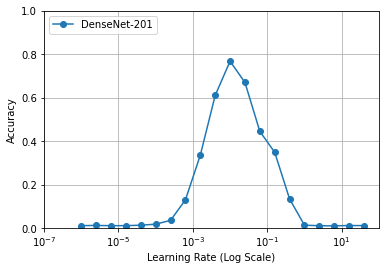

In [15]:
from matplotlib import pyplot as plt

plt.semilogx(result.history['lr'], result.history['accuracy'], label='DenseNet-201',marker='o',)
plt.axis([1e-7, 1e2, 0, 1])
plt.xlabel('Learning Rate (Log Scale)')
plt.ylabel('Accuracy')

plt.grid()
plt.legend(loc="upper left")
plt.show()



In [16]:
print(result.history['lr'])
print(result.history['accuracy'])

[1e-06, 2.5118864e-06, 6.3095736e-06, 1.5848931e-05, 3.981072e-05, 1e-04, 0.00025118864, 0.00063095737, 0.0015848932, 0.0039810715, 0.01, 0.025118865, 0.06309573, 0.15848932, 0.39810717, 1.0, 2.5118864, 6.3095737, 15.848932, 39.81072]
[0.01080117467790842, 0.011744966730475426, 0.010591442696750164, 0.01080117467790842, 0.012898489832878113, 0.017617449164390564, 0.035130035132169724, 0.12950922548770905, 0.3349412679672241, 0.6098993420600891, 0.7669882774353027, 0.6693581938743591, 0.4443162679672241, 0.34815436601638794, 0.13328438997268677, 0.012898489832878113, 0.01048657763749361, 0.009857382625341415, 0.011430368758738041, 0.010906040668487549]


In [19]:
from copy import deepcopy
import numpy as np
import keras
import math

#index of this pso
pso_index = 0

#number of neighbors (max=4)
num_neighbors = 4
#K coefficient
M = 1
u = 1

tmp_acc = 0
tmp_w = []
pbest_acc = 0
pbest_w = []

#accelerator coefficient
c1 = 0.5
c2 = 0.5
# w = 0.5

r1 = 0
r2 = 0

results_stack_accuracy = []
results_stack_val_accuracy = []
results_stack_loss = []
results_stack_val_loss = []

#
warm_up = 0

#    
# time synchronize
number_of_pso = 4
training_start_flag = 1
training_finish_flag = 0

#set initial training flag to start
set_training_flag(pso_index, training_start_flag)

for index in range(warm_up, epochs): 
# while i < iter_max:
    #start training 
    set_training_flag(pso_index, training_start_flag)
    print(get_training_flag(pso_index))
    
    #save previous weight
    model_mul.save_weights(savedfilename_pre) 
    
    # result = model_mul.fit_generator(
    #     generator = train_set, 
    #     steps_per_epoch = step_size_train,
    #     validation_data = valid_set,
    #     validation_steps = step_size_valid,
    #     shuffle=True,
    #     epochs=1,
    #     callbacks=[checkpointer,tf.keras.callbacks.LearningRateScheduler(rand_scheduler)],
    # #     callbacks=[csv_logger, checkpointer, earlystopping],
    # #     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    #     verbose=1) 

    result = model_mul.fit(
        train,
        validation_data=test,
        verbose=1,   
        epochs=1,
        callbacks=[checkpointer,tf.keras.callbacks.LearningRateScheduler(rand_scheduler)],
        # workers=2
    )   

    #save weights every iteration
#     model_mul.save_weights(savedfilename)
    
    tmp_acc = result.history.get('val_accuracy')[-1]
    tmp_w = model_mul.get_weights()
    tmp_lr = result.history.get('lr')[-1]
    
    #save current location in scoreboard
    set_c_loc(pso_index,tmp_acc) 
    
    if tmp_acc > pbest_acc:
        pbest_acc = tmp_acc
        pbest_w = tmp_w
        #save person best location
        set_pbest_loc(pso_index,pbest_acc)  
        # save best model
        model_mul.save_weights(savedfilename_best)        

    #set training flag to finish
    set_training_flag(pso_index, training_finish_flag)  
    print(get_training_flag(pso_index))
        
    # check if all PSOs is ready (flag==1)
    while(True):
        tmp_flag = 0
        for flg_i in range(number_of_pso):
            print("flg_i", flg_i, "flag", get_training_flag(flg_i))
            if(get_training_flag(flg_i) == 1):
                tmp_flag = 1
        if(tmp_flag==1):
            #waiting for 60s
            print("\n")
            for i in range(60,0,-1):
                print("waiting for ....%2d" %i, end="\r", flush=True)
                time.sleep(1)    
        else:
            print("end of waiting")
            break                          
        
    r1 = random.uniform(0,1)
    r2 = random.uniform(0,1)
#     r3 = random.uniform(0,1)    
    
    #-----------nearest neighbor best--------------
    #get neighbor weights
    #1
    neighbor_c_acc_1, name_file_1 = get_c_loc(0)
    neighbor_c_acc_2, name_file_2 = get_c_loc(1)
    neighbor_c_acc_3, name_file_3 = get_c_loc(2)
    neighbor_c_acc_4, name_file_4 = get_c_loc(3)

    #get pre loc
    neighbor_pre_acc_1, name_pre_file_1 = get_pre_loc(0)
    neighbor_pre_acc_2, name_pre_file_2 = get_pre_loc(1)
    neighbor_pre_acc_3, name_pre_file_3 = get_pre_loc(2)
    neighbor_pre_acc_4, name_pre_file_4 = get_pre_loc(3)  
    
    #clone model for weights change
    model_clone = keras.models.clone_model(model_mul)
    
    model_clone.load_weights(os.path.join('checkpoints', name_file_1))
    neighbor_w_1 = model_clone.get_weights() 
    model_clone.load_weights(os.path.join('checkpoints', name_file_2))
    neighbor_w_2 = model_clone.get_weights()
    model_clone.load_weights(os.path.join('checkpoints', name_file_3))
    neighbor_w_3 = model_clone.get_weights()
    model_clone.load_weights(os.path.join('checkpoints', name_file_4))
    neighbor_w_4 = model_clone.get_weights()
    
    #clone model pre weights
    model_clone.load_weights(os.path.join('checkpoints', name_pre_file_1))
    neighbor_pre_w_1 = model_clone.get_weights()     
    model_clone.load_weights(os.path.join('checkpoints', name_pre_file_2))
    neighbor_pre_w_2 = model_clone.get_weights() 
    model_clone.load_weights(os.path.join('checkpoints', name_pre_file_3))
    neighbor_pre_w_3 = model_clone.get_weights()    
    model_clone.load_weights(os.path.join('checkpoints', name_pre_file_4))
    neighbor_pre_w_4 = model_clone.get_weights()     
    
    distance_1 = find_distance(neighbor_w_1,neighbor_w_2)
    distance_2 = find_distance(neighbor_w_1,neighbor_w_3)
    distance_3 = find_distance(neighbor_w_1,neighbor_w_4)
    
    #find the closest neighbor
    distances = list()
    distances.append((0,0))
    distances.append((1,distance_1))
    distances.append((2,distance_2))
    distances.append((3,distance_3))

    print('distances unsorted', distances)
    
    distances.sort(key=lambda tup: tup[1])
    print('distances ', distances)
    
    neighbors_idx = list()
    for i in range(num_neighbors):
        neighbors_idx.append(distances[i][0])        
    
    print('neighbors ids ', neighbors_idx)
    
    #get neighbor bests from the list
    neighbor_bests = list()
    #remove first element (self distance)
#     neighbors_idx.pop(0)
    
    for i in range(len(neighbors_idx)):
        neighbor_best_tmp, name_file_neighbor_best_tmp = get_pbest_loc(neighbors_idx[i])
        neighbor_bests.append((neighbors_idx[i],neighbor_best_tmp))
        print('neighbor_idx ', neighbors_idx[i])
        print('neighbor_best_tmp ', neighbor_best_tmp)
    
    # keep unsorted list of neighbor
    neighbor_tmp = deepcopy(neighbor_bests)
    
    # sort the list for maximum accuracy   
    neighbor_bests.sort(key=lambda tup: tup[1], reverse=True)
    print('neighbor best ', neighbor_bests)
    #
    neighbor_best_value, name_file_neighbor_best = get_pbest_loc(neighbor_bests[0][0])
    print('name_file_neighbor_best ', name_file_neighbor_best)
    
    model_clone.load_weights(os.path.join('checkpoints', name_file_neighbor_best))
    neighbor_best_w = model_clone.get_weights()  
    #---------- end nearest neighbor best ----------
    
    #---------- cucker -----------------------------
    particle_w_i = neighbor_w_1
    sum_particle_tmp = 0
    
    #remove the fist (self)
    neighbor_tmp.pop(0)
    
    for j in range(len(neighbor_tmp)):
        if neighbor_tmp[j][0]==1:
            particle_w_j = neighbor_w_2
            particle_w_pre_j = neighbor_pre_w_2
            distance_ij = distance_1
            u = 0.2
        elif neighbor_tmp[j][0]==2:    
            particle_w_j = neighbor_w_3
            particle_w_pre_j = neighbor_pre_w_3
            distance_ij = distance_2
            u = 0.2
        elif neighbor_tmp[j][0]==3:    
            particle_w_j = neighbor_w_4
            particle_w_pre_j = neighbor_pre_w_4
            distance_ij = distance_3
            u = 10
            
        print('u ', u)
        print('distance_ij ', distance_ij)
        print('tmp_lr ', tmp_lr)
        #sum(K/(1+distance)*(particle_w_j-particle_w_i)
#         sum_particle_tmp -= M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j))
        sum_particle_tmp =  sum_particle_tmp \
                            - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
                            + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)
        
    #---------- end cucker -------------------------
    
    #---------- pbest ------------------------------
    
    #---------- end pbest --------------------------

    #update networks' weights
    #     w = c1*r1*(np.array(pbest_w)-np.array(tmp_w))+c2*r2*(np.array(gbest_w)-np.array(tmp_w))
    #     w = r1*np.array(pbest_w)+r2*np.array(tmp_w)+r3*np.array(gbest_w)
    #     w = np.array(tmp_w)+tmp_lr*(c1*r1*(np.array(pbest_w)-np.array(tmp_w))+c2*r2*(np.array(gbest_w)-np.array(tmp_w)))
#     final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))

#     final_weight = np.array(tmp_w)+sum_particle_tmp+c1*r1*(np.array(pbest_w)-np.array(tmp_w))+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))
    final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))
#     final_weight = sum_particle_tmp+np.array(neighbor_best_w)
#     final_weight = np.array(tmp_w)+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))
#     final_weight = np.array(tmp_w)+sum_particle_tmp

    model_mul.set_weights(final_weight)
    
    print('After ---> epoch=', index, ' r1=',r1, ' r2=',r2, ' current acc=', tmp_acc, ' local best=', pbest_acc, 
          ' neighbor index=', neighbor_bests[0][0], ' neighbor best=', neighbor_best_value)  
    
    results_stack_val_accuracy.append(result.history.get('val_accuracy')[-1])
    results_stack_accuracy.append(result.history.get('accuracy')[-1])
    results_stack_val_loss.append(result.history.get('val_loss')[-1])      
    results_stack_loss.append(result.history.get('loss')[-1])
    
#     i = i + 1
        
print(results_stack_val_accuracy)

1


2018-02-03 06:26:15.187063: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_44064"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1

random lr =  0.009999999776482582


2018-02-03 06:27:04.454883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2018-02-03 06:27:04.730737: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2018-02-03 06:27:04.731184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2018-02-03 06:27:04.731223: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2018-02-03 06:27:04.731648: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2018-02-03 06:27:04.731784: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1192/1192 [==============================] - ETA: 0s - loss: 2.1439 - accuracy: 0.4858

2018-02-03 06:40:55.528216: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_111958"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:23"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: 


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1043s 833ms/step - loss: 2.1439 - accuracy: 0.4858 - val_loss: 1.3861 - val_accuracy: 0.6322 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 23015.771104431595), (2, 21707.664313679623), (3, 22382.615325773346)]
distances  [(0, 0), (2, 21707.664313679623), (3, 22382.615325773346), (1, 23015.771104431595)]
neighbors ids  [0, 2, 3, 1]
neighbor_idx  0
neighbor_best_tmp  0.632150411605835
neighbor_idx  2
neighbor_best_tmp  0.0222457628697156
neighbor_idx  3
neighbor_best_tmp  0.3620232939720154
neighbor_idx  1
neighbor_best_tmp  0.3466631472110748
neighbor best  [(0, 0.632150411605835), (3, 0.3620232939720154), (1, 0.3466631472110748), (2, 0.0222457628697156)]
name_file_neighbor_best  ucf101_1_resnet152_set1_best.hdf5
u  0.2
distance_ij  21707.664313679623
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  10
distance_ij  22382.615325773346
tmp_lr  0.01
u  0.2
distance_ij  23015.771104431595
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 0  r1= 0.03893306025483978  r2= 0.9625853314118619  current acc= 0.632150411605835  local best= 0.632150411605835  neighbor index= 0  neighbor best= 0.632150411605835
1


2018-02-03 06:53:14.120105: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_179642"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:45"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: 

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.8550

2018-02-03 07:07:11.402924: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_185798"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:67"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: 


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 988s 828ms/step - loss: 0.5189 - accuracy: 0.8550 - val_loss: 1.2708 - val_accuracy: 0.6758 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 19081.354911302224), (2, 30282.566207720232), (3, 230427.17228370643)]
distances  [(0, 0), (1, 19081.354911302224), (2, 30282.566207720232), (3, 230427.17228370643)]
neighbors ids  [0, 1, 2, 3]
neighbor_idx  0
neighbor_best_tmp  0.6758474707603455
neighbor_idx  1
neighbor_best_tmp  0.6279131174087524
neighbor_idx  2
neighbor_best_tmp  0.0516419485211372
neighbor_idx  3
neighbor_best_tmp  0.3620232939720154
neighbor best  [(0, 0.6758474707603455), (1, 0.6279131174087524), (3, 0.3620232939720154), (2, 0.0516419485211372)]
name_file_neighbor_best  ucf101_1_resnet152_set1_best.hdf5
u  0.2
distance_ij  19081.354911302224
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  30282.566207720232
tmp_lr  0.01
u  10
distance_ij  230427.17228370643
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 1  r1= 0.15795073161931916  r2= 0.40050133908170604  current acc= 0.6758474707603455  local best= 0.6758474707603455  neighbor index= 0  neighbor best= 0.6758474707603455
1


2018-02-03 07:18:15.318834: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_245691"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:89"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: 

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9355

2018-02-03 07:32:15.068267: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_251847"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:111"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 994s 834ms/step - loss: 0.2343 - accuracy: 0.9355 - val_loss: 1.2368 - val_accuracy: 0.7129 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 19957.380666136152), (2, 22650.60731511296), (3, 119452.75450456487)]
distances  [(0, 0), (1, 19957.380666136152), (2, 22650.60731511296), (3, 119452.75450456487)]
neighbors ids  [0, 1, 2, 3]
neighbor_idx  0
neighbor_best_tmp  0.7129237055778503
neighbor_idx  1
neighbor_best_tmp  0.75
neighbor_idx  2
neighbor_best_tmp  0.4703389704227447
neighbor_idx  3
neighbor_best_tmp  0.7293432354927063
neighbor best  [(1, 0.75), (3, 0.7293432354927063), (0, 0.7129237055778503), (2, 0.4703389704227447)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  19957.380666136152
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  22650.60731511296
tmp_lr  0.01
u  10
distance_ij  119452.75450456487
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 2  r1= 0.8589715820750462  r2= 0.3479812726728513  current acc= 0.7129237055778503  local best= 0.7129237055778503  neighbor index= 1  neighbor best= 0.75
1


2018-02-03 07:44:23.070734: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_311740"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:133"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9658

2018-02-03 07:58:33.663503: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_317896"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:155"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1008s 845ms/step - loss: 0.1407 - accuracy: 0.9658 - val_loss: 0.8768 - val_accuracy: 0.7903 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 16288.531858438491), (2, 16089.361359762592), (3, 83639.52656764358)]
distances  [(0, 0), (2, 16089.361359762592), (1, 16288.531858438491), (3, 83639.52656764358)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7902542352676392
neighbor_idx  2
neighbor_best_tmp  0.694650411605835
neighbor_idx  1
neighbor_best_tmp  0.7640359997749329
neighbor_idx  3
neighbor_best_tmp  0.7688029408454895
neighbor best  [(0, 0.7902542352676392), (3, 0.7688029408454895), (1, 0.7640359997749329), (2, 0.694650411605835)]
name_file_neighbor_best  ucf101_1_resnet152_set1_best.hdf5
u  0.2
distance_ij  16089.361359762592
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  16288.531858438491
tmp_lr  0.01
u  10
distance_ij  83639.52656764358
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 3  r1= 0.34849189582392337  r2= 0.5339855484449194  current acc= 0.7902542352676392  local best= 0.7902542352676392  neighbor index= 0  neighbor best= 0.7902542352676392
1


2018-02-03 08:08:41.450551: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_377789"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:177"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9719

2018-02-03 08:22:38.799204: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_383945"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:199"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 992s 832ms/step - loss: 0.1049 - accuracy: 0.9719 - val_loss: 1.0786 - val_accuracy: 0.7405 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 13489.92138164414), (2, 13237.685292465372), (3, 66439.11820015624)]
distances  [(0, 0), (2, 13237.685292465372), (1, 13489.92138164414), (3, 66439.11820015624)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7902542352676392
neighbor_idx  2
neighbor_best_tmp  0.805084764957428
neighbor_idx  1
neighbor_best_tmp  0.8162076473236084
neighbor_idx  3
neighbor_best_tmp  0.7688029408454895
neighbor best  [(1, 0.8162076473236084), (2, 0.805084764957428), (0, 0.7902542352676392), (3, 0.7688029408454895)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  13237.685292465372
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  13489.92138164414
tmp_lr  0.01
u  10
distance_ij  66439.11820015624
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 4  r1= 0.6867154556054583  r2= 0.8157190399438781  current acc= 0.7404661178588867  local best= 0.7902542352676392  neighbor index= 1  neighbor best= 0.8162076473236084
1


2018-02-03 08:35:41.637384: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_440407"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:221"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9820

2018-02-03 08:49:49.547603: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_446563"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:243"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1002s 840ms/step - loss: 0.0929 - accuracy: 0.9820 - val_loss: 1.0445 - val_accuracy: 0.7487 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 13779.305114683759), (2, 12681.650206688866), (3, 116243.56364288818)]
distances  [(0, 0), (2, 12681.650206688866), (1, 13779.305114683759), (3, 116243.56364288818)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7902542352676392
neighbor_idx  2
neighbor_best_tmp  0.8072034120559692
neighbor_idx  1
neighbor_best_tmp  0.8162076473236084
neighbor_idx  3
neighbor_best_tmp  0.7688029408454895
neighbor best  [(1, 0.8162076473236084), (2, 0.8072034120559692), (0, 0.7902542352676392), (3, 0.7688029408454895)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  12681.650206688866
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  13779.305114683759
tmp_lr  0.01
u  10
distance_ij  116243.56364288818
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 5  r1= 0.5716207558198961  r2= 0.45886859929867063  current acc= 0.7486758232116699  local best= 0.7902542352676392  neighbor index= 1  neighbor best= 0.8162076473236084
1


2018-02-03 09:01:50.550873: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_503025"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:265"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9820

2018-02-03 09:15:59.418280: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_509181"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:287"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1007s 845ms/step - loss: 0.0886 - accuracy: 0.9820 - val_loss: 0.8001 - val_accuracy: 0.7916 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 9368.086015708075), (2, 8580.112750333088), (3, 112890.46199823197)]
distances  [(0, 0), (2, 8580.112750333088), (1, 9368.086015708075), (3, 112890.46199823197)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.8162076473236084
neighbor_idx  1
neighbor_best_tmp  0.8177965879440308
neighbor_idx  3
neighbor_best_tmp  0.7688029408454895
neighbor best  [(1, 0.8177965879440308), (2, 0.8162076473236084), (0, 0.7915784120559692), (3, 0.7688029408454895)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  8580.112750333088
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  9368.086015708075
tmp_lr  0.01
u  10
distance_ij  112890.46199823197
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 6  r1= 0.4014711975179365  r2= 0.4159035542493401  current acc= 0.7915784120559692  local best= 0.7915784120559692  neighbor index= 1  neighbor best= 0.8177965879440308
1


2018-02-03 09:27:07.052240: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_569074"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:309"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9836

2018-02-03 09:41:15.396037: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_575230"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:331"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1002s 840ms/step - loss: 0.0779 - accuracy: 0.9836 - val_loss: 0.9351 - val_accuracy: 0.7805 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 14091.39810975675), (2, 11336.530104026057), (3, 56952.7131915955)]
distances  [(0, 0), (2, 11336.530104026057), (1, 14091.39810975675), (3, 56952.7131915955)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.8172669410705566
neighbor_idx  1
neighbor_best_tmp  0.8177965879440308
neighbor_idx  3
neighbor_best_tmp  0.7688029408454895
neighbor best  [(1, 0.8177965879440308), (2, 0.8172669410705566), (0, 0.7915784120559692), (3, 0.7688029408454895)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  11336.530104026057
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  14091.39810975675
tmp_lr  0.01
u  10
distance_ij  56952.7131915955
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 7  r1= 0.10090161800994912  r2= 0.7576027929154834  current acc= 0.7804555296897888  local best= 0.7915784120559692  neighbor index= 1  neighbor best= 0.8177965879440308
1


2018-02-03 09:52:16.649616: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_631692"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:353"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9796

2018-02-03 10:06:25.834219: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_637848"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:375"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1000s 839ms/step - loss: 0.0960 - accuracy: 0.9796 - val_loss: 0.9767 - val_accuracy: 0.7675 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 10292.658426627104), (2, 8565.772225839983), (3, 51275.87015670682)]
distances  [(0, 0), (2, 8565.772225839983), (1, 10292.658426627104), (3, 51275.87015670682)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.8172669410705566
neighbor_idx  1
neighbor_best_tmp  0.8177965879440308
neighbor_idx  3
neighbor_best_tmp  0.7772775292396545
neighbor best  [(1, 0.8177965879440308), (2, 0.8172669410705566), (0, 0.7915784120559692), (3, 0.7772775292396545)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  8565.772225839983
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  10292.658426627104
tmp_lr  0.01
u  10
distance_ij  51275.87015670682
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 8  r1= 0.6536324576779848  r2= 0.8062736414901193  current acc= 0.7674788236618042  local best= 0.7915784120559692  neighbor index= 1  neighbor best= 0.8177965879440308
1


2018-02-03 10:17:23.247579: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_694310"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:397"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9782

2018-02-03 10:31:29.147178: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_700466"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:419"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1003s 841ms/step - loss: 0.1033 - accuracy: 0.9782 - val_loss: 1.1649 - val_accuracy: 0.7331 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 13222.605804865065), (2, 10990.719632298413), (3, 36657.5680842305)]
distances  [(0, 0), (2, 10990.719632298413), (1, 13222.605804865065), (3, 36657.5680842305)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.8172669410705566
neighbor_idx  1
neighbor_best_tmp  0.820709764957428
neighbor_idx  3
neighbor_best_tmp  0.7862817645072937
neighbor best  [(1, 0.820709764957428), (2, 0.8172669410705566), (0, 0.7915784120559692), (3, 0.7862817645072937)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  10990.719632298413
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  13222.605804865065
tmp_lr  0.01
u  10
distance_ij  36657.5680842305
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 9  r1= 0.7356274765226057  r2= 0.032591687080812726  current acc= 0.7330508232116699  local best= 0.7915784120559692  neighbor index= 1  neighbor best= 0.820709764957428
1


2018-02-03 10:43:34.313370: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_756928"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:441"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9824

2018-02-03 10:58:03.335512: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_763084"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:463"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1026s 860ms/step - loss: 0.0808 - accuracy: 0.9824 - val_loss: 0.9652 - val_accuracy: 0.7786 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 15300.112511371211), (2, 14599.850067666704), (3, 26930.89659534622)]
distances  [(0, 0), (2, 14599.850067666704), (1, 15300.112511371211), (3, 26930.89659534622)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.820709764957428
neighbor_idx  1
neighbor_best_tmp  0.8217690587043762
neighbor_idx  3
neighbor_best_tmp  0.820709764957428
neighbor best  [(1, 0.8217690587043762), (2, 0.820709764957428), (3, 0.820709764957428), (0, 0.7915784120559692)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  14599.850067666704
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  15300.112511371211
tmp_lr  0.01
u  10
distance_ij  26930.89659534622
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 10  r1= 0.9851249244524415  r2= 0.12221384253419043  current acc= 0.7786017060279846  local best= 0.7915784120559692  neighbor index= 1  neighbor best= 0.8217690587043762
1


2018-02-03 11:08:04.518485: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_819546"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:485"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9875

2018-02-03 11:22:01.178129: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_825702"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:507"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 994s 833ms/step - loss: 0.0569 - accuracy: 0.9875 - val_loss: 1.0247 - val_accuracy: 0.7717 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 14014.05244561035), (2, 15507.107072945908), (3, 21010.77411772127)]
distances  [(0, 0), (1, 14014.05244561035), (2, 15507.107072945908), (3, 21010.77411772127)]
neighbors ids  [0, 1, 2, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  1
neighbor_best_tmp  0.8220338821411133
neighbor_idx  2
neighbor_best_tmp  0.820709764957428
neighbor_idx  3
neighbor_best_tmp  0.8238877058029175
neighbor best  [(3, 0.8238877058029175), (1, 0.8220338821411133), (2, 0.820709764957428), (0, 0.7915784120559692)]
name_file_neighbor_best  ucf101_4_resnet152_set1_best.hdf5
u  0.2
distance_ij  14014.05244561035
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  15507.107072945908
tmp_lr  0.01
u  10
distance_ij  21010.77411772127
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 11  r1= 0.4919265381462119  r2= 0.7718207514284786  current acc= 0.7717161178588867  local best= 0.7915784120559692  neighbor index= 3  neighbor best= 0.8238877058029175
1


2018-02-03 11:35:06.933507: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_882164"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:529"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9898

2018-02-03 11:49:07.888580: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_888320"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:551"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 994s 833ms/step - loss: 0.0495 - accuracy: 0.9898 - val_loss: 0.9970 - val_accuracy: 0.7664 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 11730.801024695891), (2, 8186.224606854904), (3, 13631.924072529651)]
distances  [(0, 0), (2, 8186.224606854904), (1, 11730.801024695891), (3, 13631.924072529651)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.7915784120559692
neighbor_idx  2
neighbor_best_tmp  0.8265359997749329
neighbor_idx  1
neighbor_best_tmp  0.8220338821411133
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(3, 0.8275953531265259), (2, 0.8265359997749329), (1, 0.8220338821411133), (0, 0.7915784120559692)]
name_file_neighbor_best  ucf101_4_resnet152_set1_best.hdf5
u  0.2
distance_ij  8186.224606854904
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  11730.801024695891
tmp_lr  0.01
u  10
distance_ij  13631.924072529651
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 12  r1= 0.0644068183061316  r2= 0.2908891004929127  current acc= 0.7664194703102112  local best= 0.7915784120559692  neighbor index= 3  neighbor best= 0.8275953531265259
1


2018-02-03 12:01:07.533742: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_944782"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:573"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9920

2018-02-03 12:15:20.670261: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_950938"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:595"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1005s 843ms/step - loss: 0.0441 - accuracy: 0.9920 - val_loss: 0.7855 - val_accuracy: 0.8183 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 11084.525722578204), (2, 10924.944675259192), (3, 151785.30984896023)]
distances  [(0, 0), (2, 10924.944675259192), (1, 11084.525722578204), (3, 151785.30984896023)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8265359997749329
neighbor_idx  1
neighbor_best_tmp  0.8244173526763916
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(3, 0.8275953531265259), (2, 0.8265359997749329), (1, 0.8244173526763916), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_4_resnet152_set1_best.hdf5
u  0.2
distance_ij  10924.944675259192
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  11084.525722578204
tmp_lr  0.01
u  10
distance_ij  151785.30984896023
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 13  r1= 0.03427698568929405  r2= 0.831145614163876  current acc= 0.8183262944221497  local best= 0.8183262944221497  neighbor index= 3  neighbor best= 0.8275953531265259
1


2018-02-03 12:26:22.712230: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1010831"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:617"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9923

2018-02-03 12:40:22.302364: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1016987"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:639"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 992s 832ms/step - loss: 0.0443 - accuracy: 0.9923 - val_loss: 0.7590 - val_accuracy: 0.8167 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 17249.158713887948), (2, 9384.879492574528), (3, 127826.618037306)]
distances  [(0, 0), (2, 9384.879492574528), (1, 17249.158713887948), (3, 127826.618037306)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8265359997749329
neighbor_idx  1
neighbor_best_tmp  0.8275953531265259
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(1, 0.8275953531265259), (3, 0.8275953531265259), (2, 0.8265359997749329), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  9384.879492574528
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  17249.158713887948
tmp_lr  0.01
u  10
distance_ij  127826.618037306
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 14  r1= 0.39544519587785687  r2= 0.30054620441929913  current acc= 0.8167372941970825  local best= 0.8183262944221497  neighbor index= 1  neighbor best= 0.8275953531265259
1


2018-02-03 12:52:24.418051: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1073449"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:661"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9908

2018-02-03 13:06:18.585659: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1079605"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:683"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 992s 832ms/step - loss: 0.0472 - accuracy: 0.9908 - val_loss: 0.8060 - val_accuracy: 0.8030 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 14184.299868810944), (2, 8972.148023002357), (3, 68235.22884974701)]
distances  [(0, 0), (2, 8972.148023002357), (1, 14184.299868810944), (3, 68235.22884974701)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8273305296897888
neighbor_idx  1
neighbor_best_tmp  0.8291842937469482
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(1, 0.8291842937469482), (3, 0.8275953531265259), (2, 0.8273305296897888), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  8972.148023002357
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  14184.299868810944
tmp_lr  0.01
u  10
distance_ij  68235.22884974701
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 15  r1= 0.5925144944040674  r2= 0.773755959356008  current acc= 0.8029661178588867  local best= 0.8183262944221497  neighbor index= 1  neighbor best= 0.8291842937469482
1


2018-02-03 13:17:23.469684: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1136067"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:705"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9870

2018-02-03 13:31:22.818082: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1142223"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:727"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 993s 832ms/step - loss: 0.0621 - accuracy: 0.9870 - val_loss: 0.9602 - val_accuracy: 0.7860 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 32681.506676927635), (2, 25910.606161606684), (3, 45843.00771303054)]
distances  [(0, 0), (2, 25910.606161606684), (1, 32681.506676927635), (3, 45843.00771303054)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8283898234367371
neighbor_idx  1
neighbor_best_tmp  0.8291842937469482
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(1, 0.8291842937469482), (2, 0.8283898234367371), (3, 0.8275953531265259), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_2_resnet152_set1_best.hdf5
u  0.2
distance_ij  25910.606161606684
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  32681.506676927635
tmp_lr  0.01
u  10
distance_ij  45843.00771303054
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 16  r1= 0.7155470041794687  r2= 0.1722115224811478  current acc= 0.7860169410705566  local best= 0.8183262944221497  neighbor index= 1  neighbor best= 0.8291842937469482
1


2018-02-03 13:43:24.664514: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1198685"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:749"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9911

2018-02-03 13:57:33.181137: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1204841"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:771"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 1006s 843ms/step - loss: 0.0466 - accuracy: 0.9911 - val_loss: 0.8246 - val_accuracy: 0.8125 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 20456.99909948208), (2, 18749.726390477852), (3, 50816.30149549167)]
distances  [(0, 0), (2, 18749.726390477852), (1, 20456.99909948208), (3, 50816.30149549167)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8299788236618042
neighbor_idx  1
neighbor_best_tmp  0.8291842937469482
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(2, 0.8299788236618042), (1, 0.8291842937469482), (3, 0.8275953531265259), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_3_resnet152_set1_best.hdf5
u  0.2
distance_ij  18749.726390477852
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  20456.99909948208
tmp_lr  0.01
u  10
distance_ij  50816.30149549167
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 17  r1= 0.9565913758771278  r2= 0.3293201891033267  current acc= 0.8125  local best= 0.8183262944221497  neighbor index= 2  neighbor best= 0.8299788236618042
1


2018-02-03 14:08:37.079631: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1261303"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:793"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9917

2018-02-03 14:22:29.223947: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1267459"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:815"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 985s 826ms/step - loss: 0.0434 - accuracy: 0.9917 - val_loss: 0.9395 - val_accuracy: 0.7828 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 17245.407591223135), (2, 14217.386954109092), (3, 38218.656823529695)]
distances  [(0, 0), (2, 14217.386954109092), (1, 17245.407591223135), (3, 38218.656823529695)]
neighbors ids  [0, 2, 1, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  2
neighbor_best_tmp  0.8299788236618042
neighbor_idx  1
neighbor_best_tmp  0.8291842937469482
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(2, 0.8299788236618042), (1, 0.8291842937469482), (3, 0.8275953531265259), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_3_resnet152_set1_best.hdf5
u  0.2
distance_ij  14217.386954109092
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  17245.407591223135
tmp_lr  0.01
u  10
distance_ij  38218.656823529695
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 18  r1= 0.8996251766473877  r2= 0.9143167015337254  current acc= 0.7828390002250671  local best= 0.8183262944221497  neighbor index= 2  neighbor best= 0.8299788236618042
1


2018-02-03 14:34:28.785641: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1323921"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:837"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size

random lr =  0.009999999776482582
1192/1192 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9875

2018-02-03 14:48:24.260187: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1330077"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:859"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size


Epoch 1: saving model to checkpoints/ucf101_1_resnet152_set1.hdf5
1192/1192 [==============================] - 992s 832ms/step - loss: 0.0596 - accuracy: 0.9875 - val_loss: 0.8419 - val_accuracy: 0.7913 - lr: 0.0100
0
flg_i 0 flag 0
flg_i 1 flag 1
flg_i 2 flag 1
flg_i 3 flag 1


flg_i 0 flag 0.. 1
flg_i 1 flag 0
flg_i 2 flag 0
flg_i 3 flag 0
end of waiting


/tmp/ipykernel_5414/1838896777.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_1 = np.array(w1)
/tmp/ipykernel_5414/1838896777.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_np_2 = np.array(w2)


distances unsorted [(0, 0), (1, 9440.864408046296), (2, 9811.248669808265), (3, 33415.154818732284)]
distances  [(0, 0), (1, 9440.864408046296), (2, 9811.248669808265), (3, 33415.154818732284)]
neighbors ids  [0, 1, 2, 3]
neighbor_idx  0
neighbor_best_tmp  0.8183262944221497
neighbor_idx  1
neighbor_best_tmp  0.8291842937469482
neighbor_idx  2
neighbor_best_tmp  0.8299788236618042
neighbor_idx  3
neighbor_best_tmp  0.8275953531265259
neighbor best  [(2, 0.8299788236618042), (1, 0.8291842937469482), (3, 0.8275953531265259), (0, 0.8183262944221497)]
name_file_neighbor_best  ucf101_3_resnet152_set1_best.hdf5
u  0.2
distance_ij  9440.864408046296
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  - M*u/(1+distance_ij)*(np.array(particle_w_pre_j)-np.array(particle_w_j)) \
/tmp/ipykernel_5414/841431348.py:232: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  + M*u*tmp_lr/(1+distance_ij)*np.array(particle_w_j)


u  0.2
distance_ij  9811.248669808265
tmp_lr  0.01
u  10
distance_ij  33415.154818732284
tmp_lr  0.01


/tmp/ipykernel_5414/841431348.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_weight = np.array(tmp_w)+sum_particle_tmp+c2*r2*(np.array(neighbor_best_w)-np.array(tmp_w))


After ---> epoch= 19  r1= 0.3447968223015806  r2= 0.5485894529927247  current acc= 0.7913135886192322  local best= 0.8183262944221497  neighbor index= 2  neighbor best= 0.8299788236618042
[0.632150411605835, 0.6758474707603455, 0.7129237055778503, 0.7902542352676392, 0.7404661178588867, 0.7486758232116699, 0.7915784120559692, 0.7804555296897888, 0.7674788236618042, 0.7330508232116699, 0.7786017060279846, 0.7717161178588867, 0.7664194703102112, 0.8183262944221497, 0.8167372941970825, 0.8029661178588867, 0.7860169410705566, 0.8125, 0.7828390002250671, 0.7913135886192322]


In [ ]:
#0.8219 lr=1e-1
#0.8265 lr=1e-2
#0.8472 Dynamics 1

In [21]:
print(max(results_stack_val_accuracy))

0.8183262944221497


In [ ]:
result = model_mul.fit(
    train,
    validation_data=test,
    verbose=1,   
    epochs=100,
    callbacks=[checkpointer,tf.keras.callbacks.LearningRateScheduler(rand_scheduler)],
    # workers=2
)  

In [ ]:

# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip

In [31]:
# %%capture
# !unrar e UCF101.rar data/
# !unzip -qq UCF101TrainTestSplits-RecognitionTask.zip

In [ ]:
# move_videos(train_new, "train")
# move_videos(test_new, "test")

In [ ]:
ls -l

In [ ]:
# %mv UCF101.rar ucf101_v2
# %mv UCF101TrainTestSplits-RecognitionTask.zip ucf101_v2
# %mkdir ucf101_v2/set1
# %mv train ucf101_v2/set1
# %mv test ucf101_v2/set1
# %mv data ucf101_v2

In [ ]:
cd ../..

In [ ]:
print(max(result.history.get('val_accuracy')))

In [ ]:
print(max(result.history.get('val_accuracy')))

In [46]:
ls -l

total 6771220
drwxrwxr-x 2 bribeiro bribeiro     622592 set  5  2022 data/
drwxrwxr-x 5 bribeiro bribeiro       4096 fev  3 05:25 set1/
drwxrwxr-x 4 bribeiro bribeiro       4096 fev  4 04:26 set2/
-rw-rw-r-- 1 bribeiro bribeiro 6932971618 nov 21  2012 UCF101.rar
-rw-rw-r-- 1 bribeiro bribeiro     113943 out 18  2013 UCF101TrainTestSplits-RecognitionTask.zip
drwxrwxr-x 2 bribeiro bribeiro       4096 jul 21  2013 ucfTrainTestlist/


In [45]:
%mv train set2
%mv test set2

In [44]:
mkdir set2

In [25]:
cd data

/media/datastorage/Phong/ucf101_v2/data
